<a href="https://colab.research.google.com/github/kstyle2198/NLP_TIPS/blob/main/QM_BERT_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@erkajalkumari/building-language-models-a-step-by-step-bert-implementation-guide-96c9930b9536

# Import Required Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# specify GPU
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset02.xlsx to dataset02.xlsx


In [4]:
df = pd.read_excel("dataset02.xlsx")
df.head(1)
df.shape

,호선,H.C/Close,진행상태,부서진행상태,QM확인,SCAS_CNO,코멘트번호,ORI_CMT_NO,제목,문제내용,...,DESC.,주관부서,검사결과,처리부서 미조치,LQC 소속,LQC 이름,Maker A/S,자재입고,S/T3,G/T4
0,3040,Indeterminate,CLOSED,QM확인완료,Unchecked,NaN,C-3040-B-AB-00001,NaN,Bunker specification using the sea trial to be...,Bunker specification using the sea trial to be...,...,NaN,NaN,NaN,N,NaN,NaN,Indeterminate,Indeterminate,Indeterminate,Indeterminate


(47741, 83)

# 전처리

In [5]:
df = df[["호선", "코멘트번호", "제목", "문제내용", "처리부서", "처리과", "회신내용", "구역", "LOCATION", "BLOCK"]]
df.shape

(47741, 10)

In [6]:
text_to_drop = ['이관', "재지정", "재 지정"]
for drop_word in text_to_drop:
    df = df[~df['회신내용'].str.contains(drop_word, regex=True, na=False)]
df.shape

(46145, 10)

In [7]:
def contains_word(main_string, target_word):
    return target_word in main_string

기준직능 = ["선장", "기장","전장", "선실", "엔진", "기관", "기계", "도장", "건조", "시운전","발판", "보냉", "공사"]
         #"의장", "설계","선행",

def 직능구하기(string):
    global 기준직능
    result = "일반"
    for 직능 in 기준직능:
        if contains_word(str(string), 직능):
            result = 직능
        else:
            pass
    return result

df["직능"] = df["처리과"].apply(직능구하기)

df["직능"].fillna("일반", inplace=True)
df["직능"].value_counts()

<ipython-input-7-8af070b3adad>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["직능"] = df["처리과"].apply(직능구하기)
<ipython-input-7-8af070b3adad>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["직능"].fillna("일반", inplace=True)


일반     15135
기장      7894
전장      7537
선장      3889
선실      3847
공사      2219
도장      1568
엔진      1564
기계       937
기관       636
시운전      500
건조       302
발판        70
보냉        47
Name: 직능, dtype: int64

In [8]:
df['직능'] = df['직능'].str.replace("보냉", '도장', regex=True)
df['직능'] = df['직능'].str.replace("발판", '도장', regex=True)

<ipython-input-8-c39a487450cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['직능'] = df['직능'].str.replace("보냉", '도장', regex=True)


In [9]:
df.shape
df = df[df["직능"]!="일반"]
df.shape

(46145, 11)

(31010, 11)

In [10]:
df = df.drop_duplicates(subset='코멘트번호', keep='first')
df.shape

(22668, 11)

In [11]:
import functools # not required, but helps in production
def unpack_df_columns(func):

    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):

        series = args[0]
        return func(*series.values)

    return _unpack_df_columns

def jaccard_simil(a, b):
    intersection_cardinality = len(set.intersection(*[set(str(a)), set(str(b))]))
    union_cardinality = len(set.union(*[set(str(a)), set(str(b))]))
    similar = intersection_cardinality / float(union_cardinality)
    return similar

@unpack_df_columns
def 문장병합(제목, 문제내용):
    '''
    자카드유사도가 일정 수준 이상이면 제목과 문제내용중 길이가 긴 내용만 살리기
    '''
    자카드유사도 = jaccard_simil(제목, 문제내용)
    thresh = 0.9  # 유사도 커트라인

    if 자카드유사도 > thresh:
        if len(str(제목)) > len(str(문제내용)):
            return 문제내용
        else:
            return 제목
    else:
        return f"{제목} {문제내용}"

In [12]:
df['comment'] = df[['제목',"문제내용"]].apply(문장병합, axis=1)
df.dropna(subset=["comment"], inplace=True)

In [13]:
korean_pattern = '[\u3131-\u3163\uac00-\ud7a3]+'
df = df[~df['comment'].str.contains(korean_pattern, regex=True)]

In [14]:
df1 =df[["comment", "직능"]]
df1.columns = ["text", "label"]
df1 = df1.reset_index(drop=True)
df1.head(2)

,text,label
0,Bunker specification using the sea trial to be...,기관
1,1. The following operational procedures are to...,기장


In [15]:
new_labels = {'기관':0, '기장':1, '선장':2, '전장':3, '선실':4, '건조':5, '시운전':6, '도장':7, '엔진':8, '기계':9, '공사':10}
df1["label"] = df1["label"].replace(to_replace=new_labels)
df1["label"]

0        0
1        1
2        0
3        1
4        2
        ..
18919    3
18920    4
18921    6
18922    3
18923    2
Name: label, Length: 18924, dtype: int64

In [16]:
classes = new_labels.keys()
classes = list(classes)
classes, len(classes)

(['기관', '기장', '선장', '전장', '선실', '건조', '시운전', '도장', '엔진', '기계', '공사'], 11)

In [17]:
df1.head(2)

,text,label
0,Bunker specification using the sea trial to be...,0
1,1. The following operational procedures are to...,1


In [18]:
# check class distribution
df1['label'].value_counts(normalize = True)

1     0.265800
3     0.241334
2     0.141144
4     0.096861
10    0.080691
8     0.064997
7     0.050201
9     0.021877
0     0.016857
6     0.011467
5     0.008772
Name: label, dtype: float64

# Split the Dataset into train/test

In [19]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df1['text'], df1['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df1['label'])
train_text.shape, temp_text.shape, train_labels.shape, temp_labels.shape

((13246,), (5678,), (13246,), (5678,))

In [20]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)
val_text.shape, test_text.shape, val_labels.shape, test_labels.shape

((2839,), (2839,), (2839,), (2839,))

# Import BERT-Base-Uncased

In [21]:
model_name = 'bert-base-uncased'
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(model_name)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
seq_len[:5]

[12, 19, 4, 28, 29]

<Axes: >

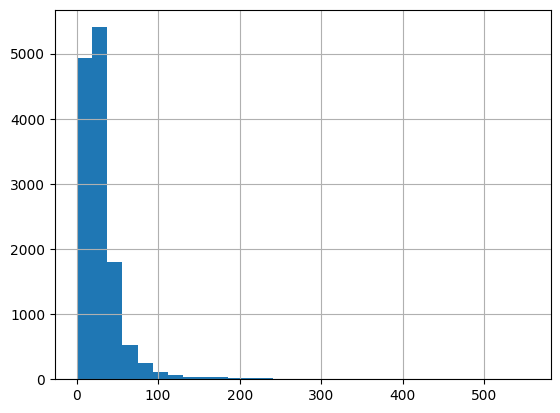

In [23]:
pd.Series(seq_len).hist(bins = 30)

# Tokenize & Encode the Sequences

In [24]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [26]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [27]:
train_labels

16827    4
13544    1
5086     4
766      7
13239    3
        ..
8757     1
16806    3
12438    7
3155     7
806      1
Name: label, Length: 13246, dtype: int64

# List to Tensors

In [28]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [30]:
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Model Architecture

In [31]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [32]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    # dropout layer
    self.dropout = nn.Dropout(0.1)
    # relu activation function
    self.relu =  nn.ReLU()
    # dense layer 1
    self.fc1 = nn.Linear(768,512)
    # dense layer 2 (Output layer)   ##### 라벨 개수에 따라 수정해야 하는 부분###########################
    self.fc2 = nn.Linear(512,11)
    #softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  #define the forward pass
  def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)
      return x

# GPU Acceleration

In [33]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [34]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
!pip install scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [36]:
# 에러관련 참고 링크 : https://street-developer.tistory.com/11

from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [ 5.39991847  0.34199995  0.64429204  0.37665994  0.93856728 10.38087774
  7.9222488   1.81079973  1.39858515  4.1523511   1.12645633]


In [37]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

In [38]:
# push to GPU
weights = weights.to(device)
# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)
# number of training epochs
epochs = 10

# Fine-Tune

In [39]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [40]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()


    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            # elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Train the Model

In [41]:
# set initial loss to infinite
best_valid_loss = float('inf')

In [42]:
#defining epochs
epochs = 50
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    414.
  Batch   100  of    414.
  Batch   150  of    414.
  Batch   200  of    414.
  Batch   250  of    414.
  Batch   300  of    414.
  Batch   350  of    414.
  Batch   400  of    414.

Evaluating...
  Batch    50  of     89.

Training Loss: 2.391
Validation Loss: 2.381

 Epoch 2 / 50
  Batch    50  of    414.
  Batch   100  of    414.
  Batch   150  of    414.
  Batch   200  of    414.
  Batch   250  of    414.
  Batch   300  of    414.
  Batch   350  of    414.
  Batch   400  of    414.

Evaluating...
  Batch    50  of     89.

Training Loss: 2.383
Validation Loss: 2.371

 Epoch 3 / 50
  Batch    50  of    414.
  Batch   100  of    414.
  Batch   150  of    414.
  Batch   200  of    414.
  Batch   250  of    414.
  Batch   300  of    414.
  Batch   350  of    414.
  Batch   400  of    414.

Evaluating...
  Batch    50  of     89.

Training Loss: 2.376
Validation Loss: 2.365

 Epoch 4 / 50
  Batch    50  of    414.
  Batch   100  of    414.
  Batc

In [43]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Make Predictions

In [44]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [45]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.07      0.08      0.08        48
           1       0.45      0.24      0.32       754
           2       0.29      0.17      0.22       401
           3       0.56      0.28      0.38       685
           4       0.19      0.40      0.26       275
           5       0.08      0.04      0.05        25
           6       0.09      0.03      0.05        32
           7       0.12      0.48      0.19       143
           8       0.32      0.57      0.41       185
           9       0.00      0.00      0.00        62
          10       0.22      0.23      0.23       229

    accuracy                           0.28      2839
   macro avg       0.22      0.23      0.20      2839
weighted avg       0.36      0.28      0.29      2839



             precision    recall  f1-score   support

           0       0.73      0.50      0.59       278
           1       0.36      0.59      0.44       129

    accuracy                           0.53       407
   macro avg       0.54      0.55      0.52       407
weighted avg       0.61      0.53      0.55       407